## <center> **SIREN**: Sinusoidal Representation Networks
###### <center> _Sitzmann, V., Martel, J., Bergman, A., Lindell, D., and Wetzstein, G. 2020. [Implicit Neural Representations with Periodic Activation Functions](https://www.vincentsitzmann.com/siren/). In Proc. NeurIPS._

## <center> Audio Mapping Function
### $$ f(t): \mathbb{R} \to \mathbb{R} $$

### $$ \text{Cordinate Map}: \mathbb{R} \to \mathbb{R} : [t] \to [A] $$
### $$ \text{Feature Map}: \mathbb{R}^{\text{features}} \to \mathbb{R} : [t_{1 \cdots k}] \to [A] $$
### $$ \text{Final Map}: \mathbb{R} \to \mathbb{R}^{\text{features}} \to \mathbb{R} : [t] \to [t_{1 \cdots k}] \to [A] $$

### Run **only in Colab or Linux** to install Latex Fonts and add `latexify.py` in the upload files

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

from latexify import latexify
latexify(columns = 2)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Get the Audio File

In [ ]:
# !wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

--2024-08-30 09:33:42--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.1’

gt_bach.wav.1       100%[===================>]   1.17M  --.-KB/s    in 0.04s   

2024-08-30 09:33:42 (30.0 MB/s) - ‘gt_bach.wav.1’ saved [1232886/1232886]



In [ ]:
from IPython.display import Audio
Audio(filename=r'/content/mixkit-suspense-movie-transition-sound-2910.wav')

In [ ]:
import torchaudio
audio, sr = torchaudio.load(r'/content/mixkit-suspense-movie-transition-sound-2910.wav')

$$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $$

In [ ]:
sr

44100

In [ ]:
print(audio.shape)
audio = audio[0]

torch.Size([2, 250539])


In [ ]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 5.681156462585034 seconds


In [ ]:
audio

tensor([ 0.0000e+00, -3.0518e-05,  6.1035e-05,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])

In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

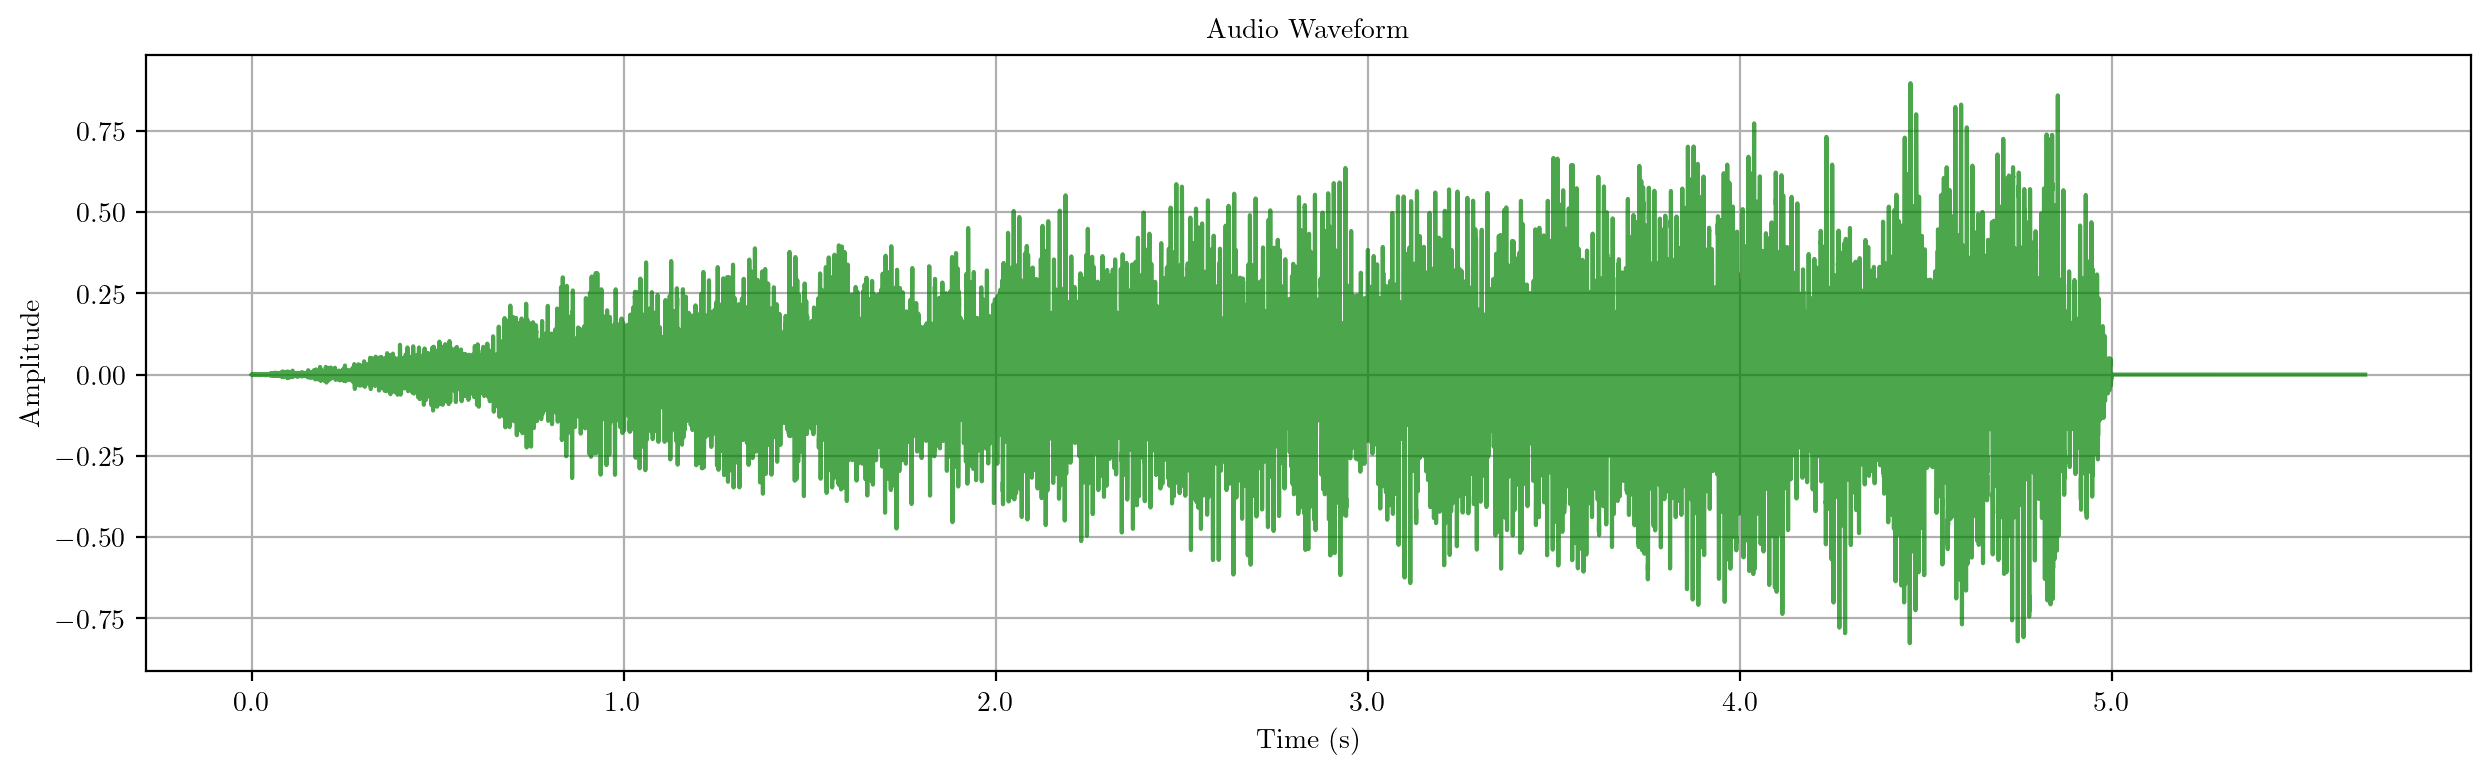

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Using the last 2 seconds of the Audio

In [ ]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)

torch.Size([88200])
tensor([-1.2097e-01, -1.1371e-01, -1.0635e-01,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])


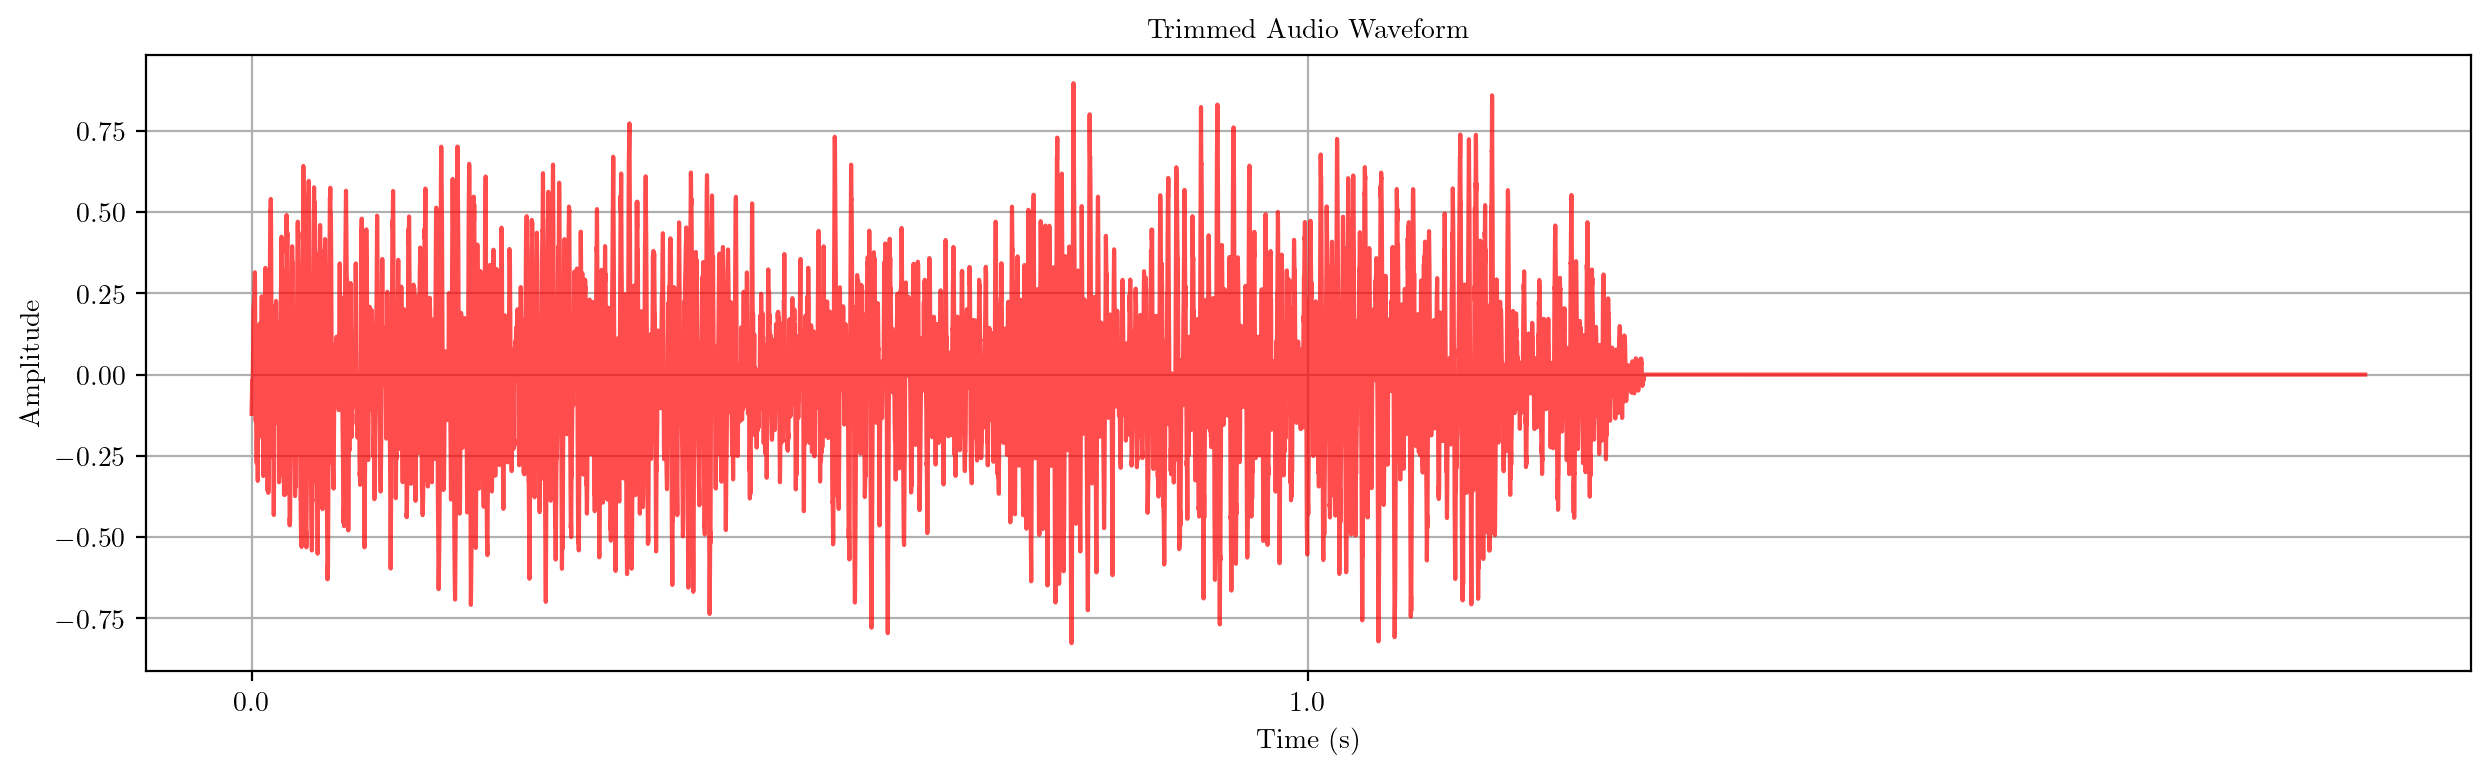

In [ ]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


In [ ]:
Audio(audio, rate = sr)

### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
###### _(Rahimi, A., & Recht, B. (2007). [Random features for large-scale kernel machines](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html). Advances in Neural Information Processing Systems, 1177–1184.)_

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


## Fit a Linear Model over this expanded feature domain
### $\textbf{X}_{(88200, 5000)}, \textbf{y}_{(88200, )}$

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


### On saving the model weights and sound file

In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [ ]:
print(pred_audio)
print(audio)

[-0.1308591  -0.12210057 -0.11295674 ...  0.08076789  0.08217456
  0.08142402]
tensor([-1.2097e-01, -1.1371e-01, -1.0635e-01,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(45.380333, 10420.113)

## Reconstructed Audio

In [ ]:
Audio(pred_audio, rate = sr)

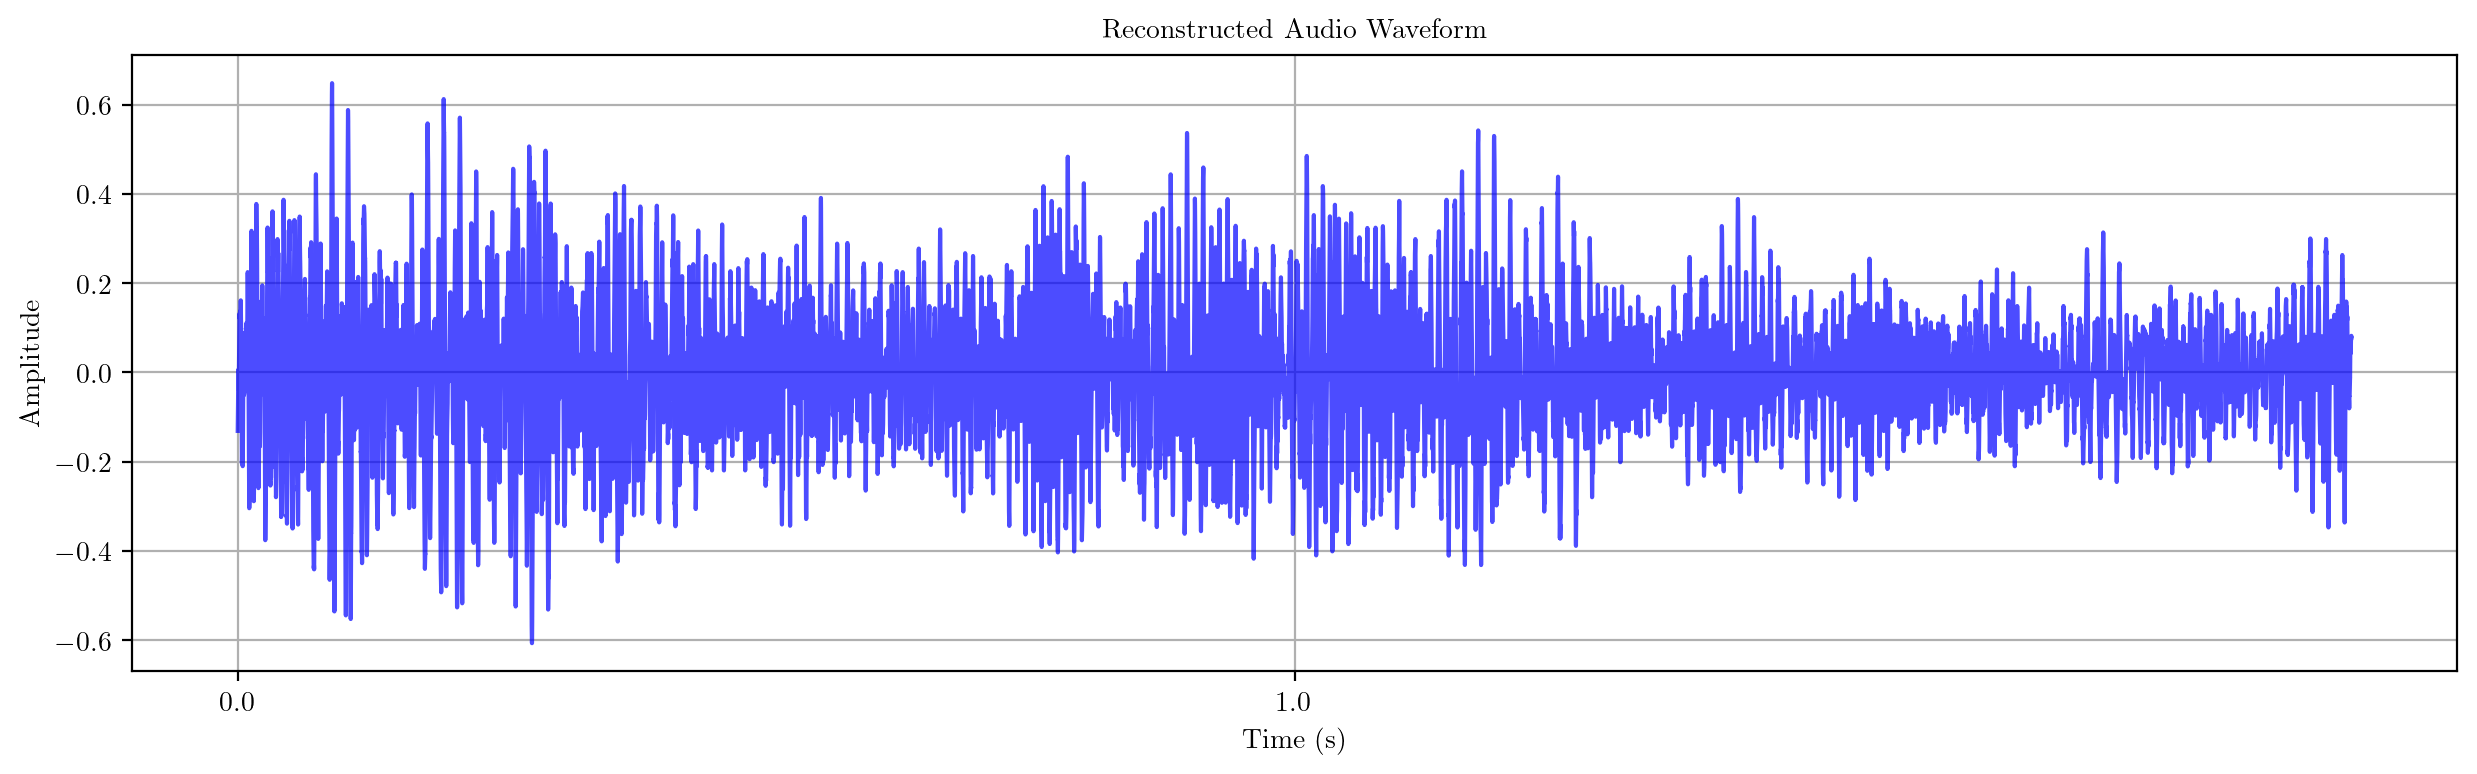

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

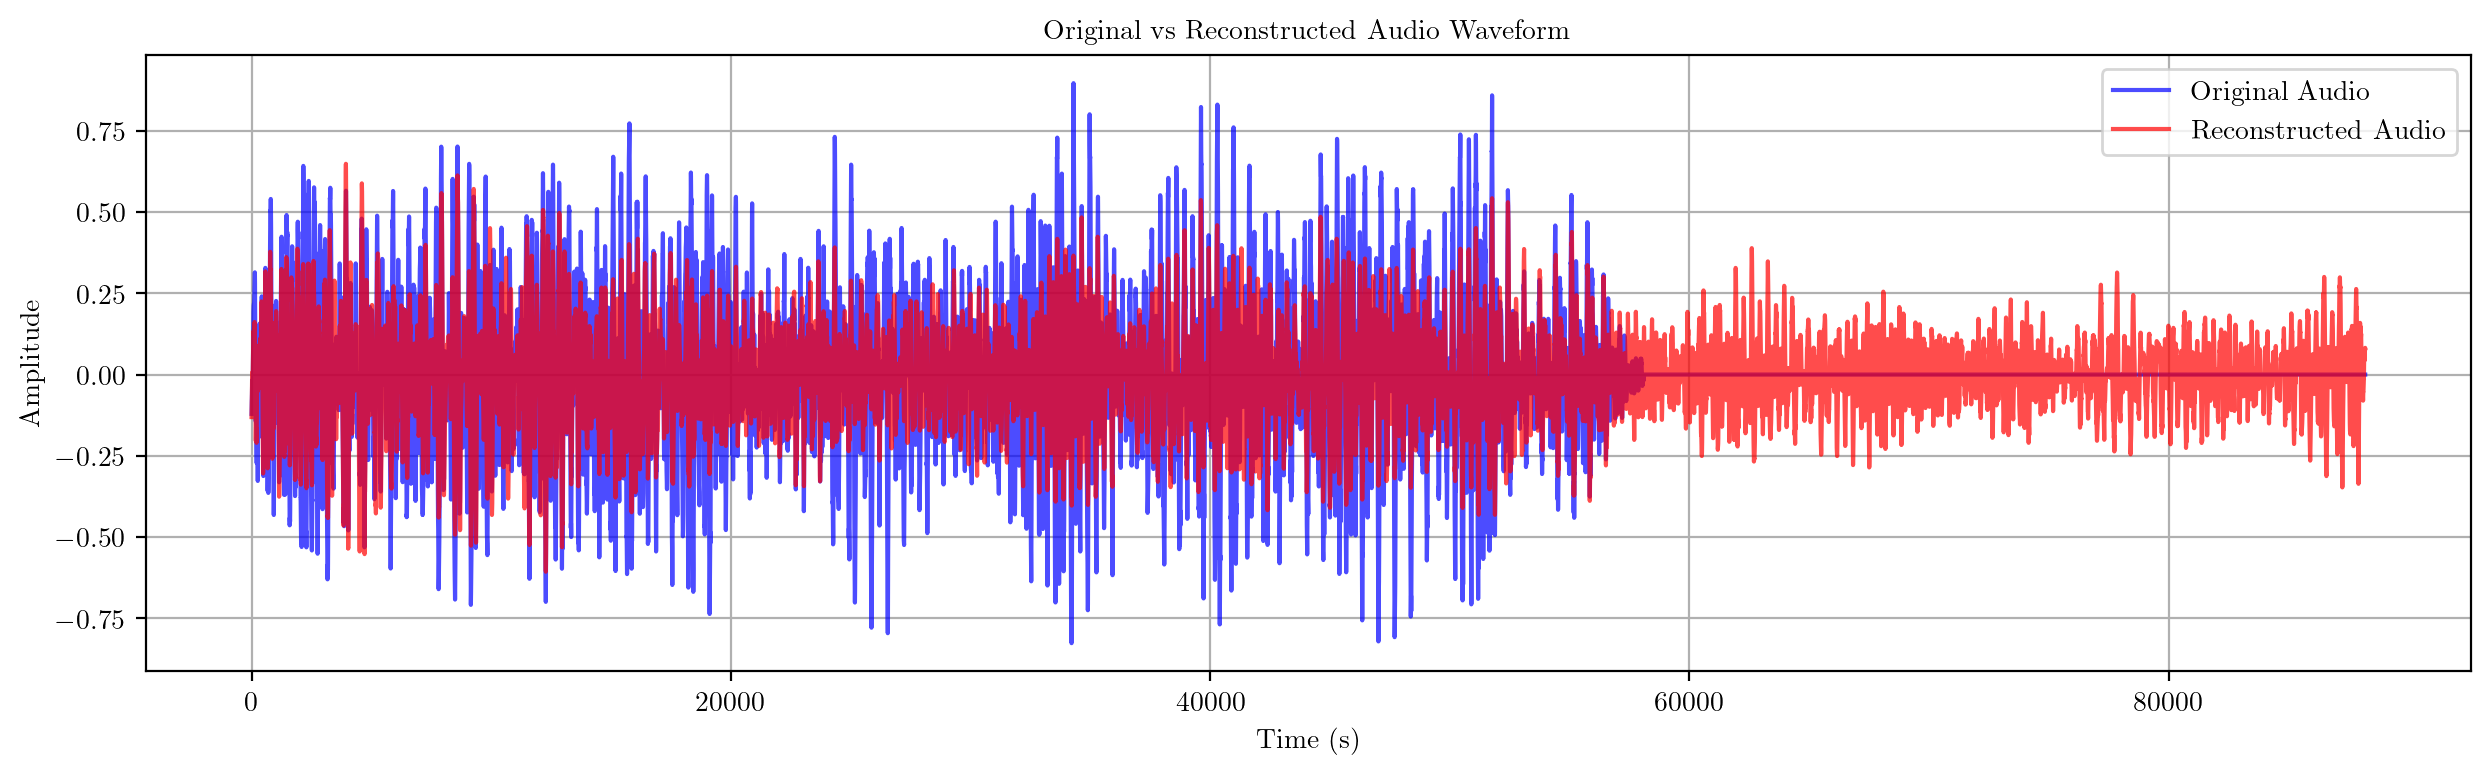

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

### Interpolation

#### We remove out 10,000 continuous samples from the time series
#### $\textbf{X}_{(:\text{start}, 5000) \cup (\text{end}:, 5000)}, \textbf{y}_{(:\text{start},) \cup (\text{end}:,)}$

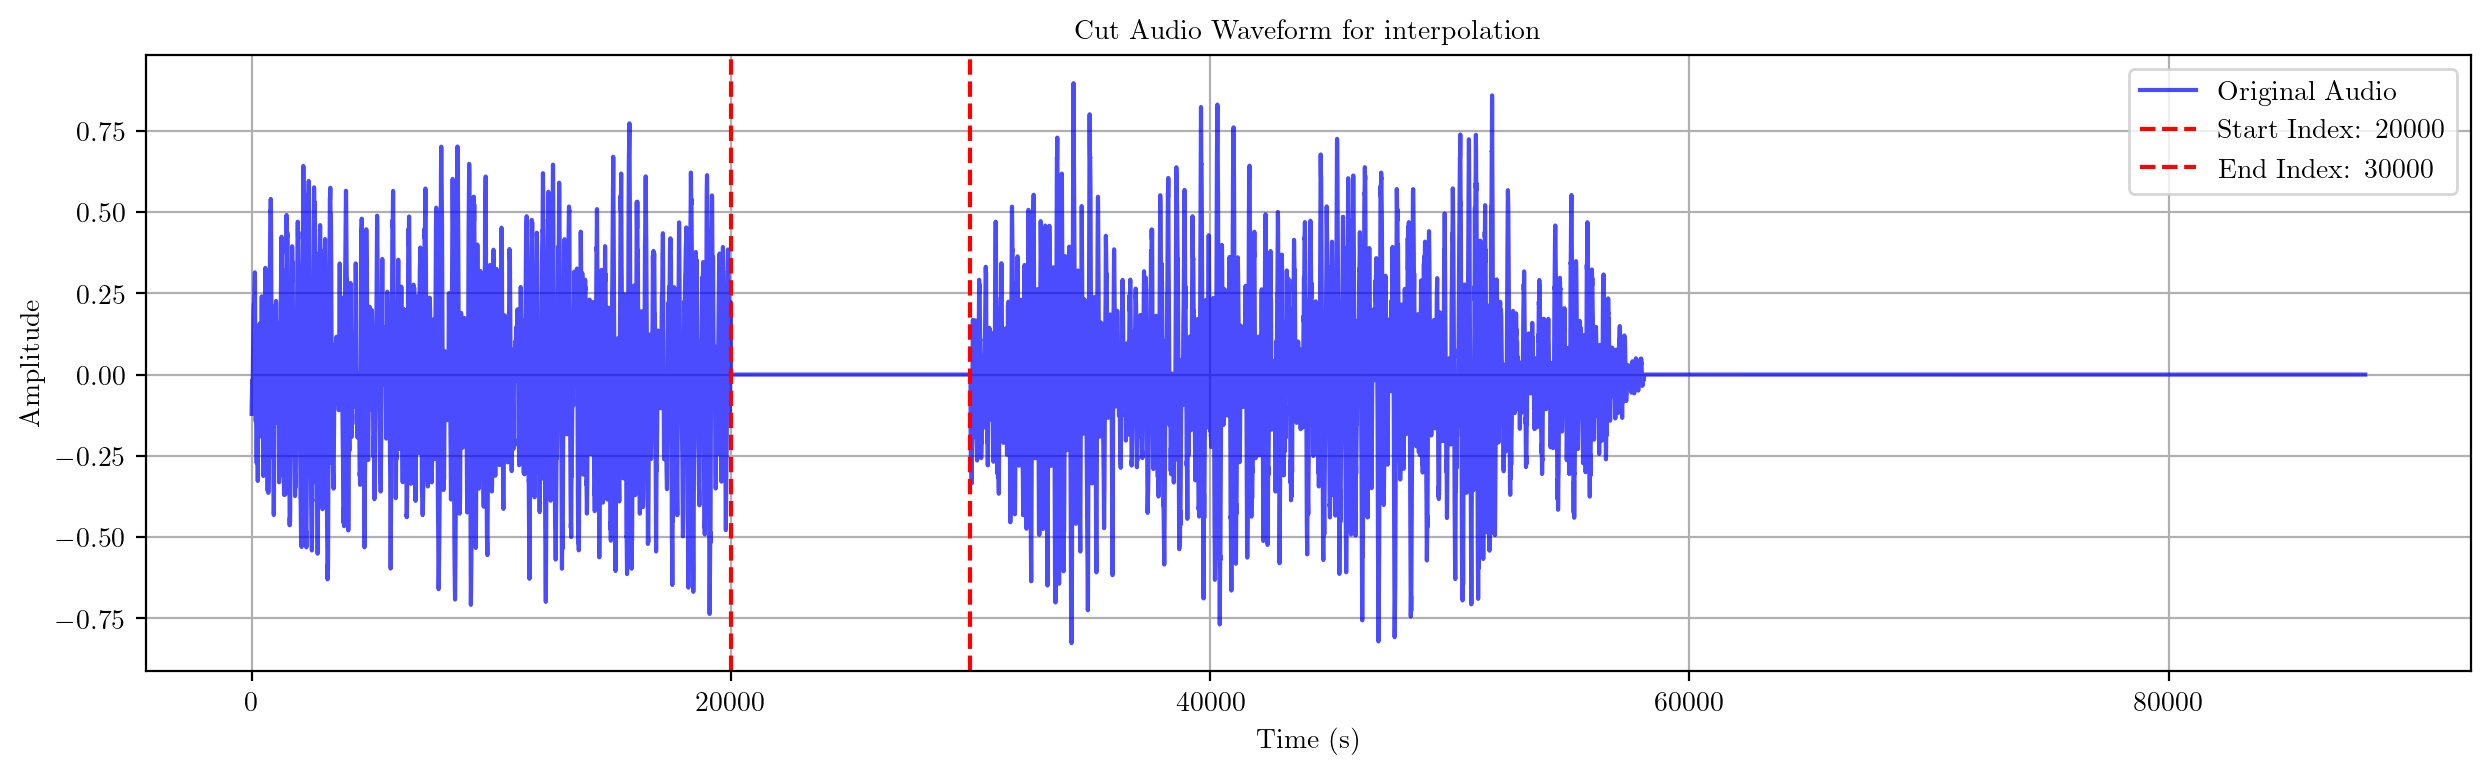

In [ ]:
start_idx = 20000
end_idx = 30000

audio_new = audio.clone()
audio_new[start_idx : end_idx] = 0

plt.figure(figsize=(15, 4))
plt.plot(audio_new, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Cut Audio Waveform for interpolation')
plt.grid()
plt.legend()
plt.show()

#### Extract out the $\textbf{X}[:\text{start}]$ $\textbf{X}[\text{end}:]$, $\textbf{y}[:\text{start}]$  $\textbf{y}[\text{end}:]$ and then concatentate them

In [ ]:
X_rff1 = X_rff[:start_idx]
X_rff2 = X_rff[end_idx:]

audio1 = audio[:start_idx]
audio2 = audio[end_idx:]

# concate X_rff1 and X_rff2
X_rffF = torch.cat((X_rff1, X_rff2), dim = 0)

# concate audio1 and audio2
audioF = torch.cat((audio1, audio2), dim = 0)

In [ ]:
print(X_rffF.shape)
print(audioF.shape)

torch.Size([78200, 5000])
torch.Size([78200])


### Fit the Linear model on the left out portion `X_rffF`

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rffF.numpy(), audioF)

LinearRegression()

### But predict on the entire `X_rff`

In [ ]:
pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


In [ ]:
print(pred_audio)
print(audio)

[-0.09664104 -0.08910892 -0.0788779  ...  0.10019543  0.10409787
  0.10461285]
tensor([-1.2097e-01, -1.1371e-01, -1.0635e-01,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])


In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(50.487476, 10888.428)

### Interpolated Audio

In [ ]:
Audio(pred_audio, rate = sr)

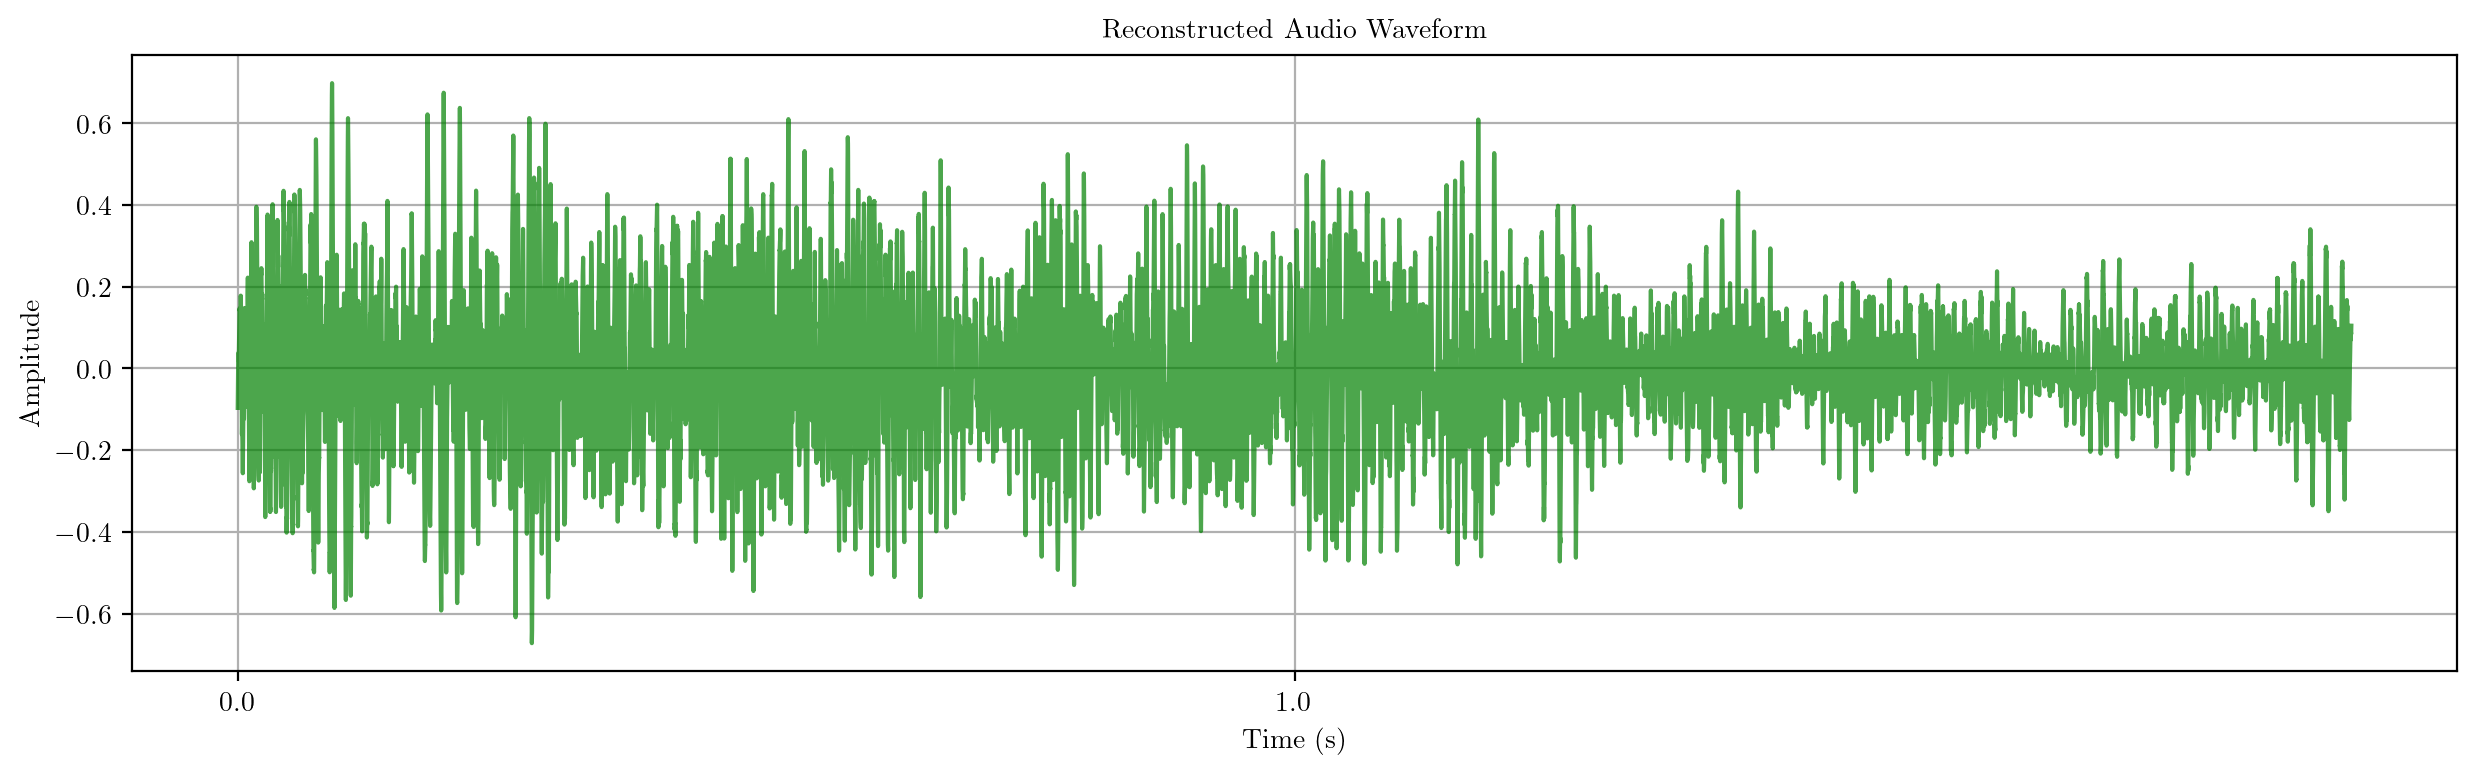

In [ ]:
audio_plot(pred_audio, sr, 'green', 'Reconstructed Audio Waveform')

### Comparison of original waveform to interpolated reconstructed audio

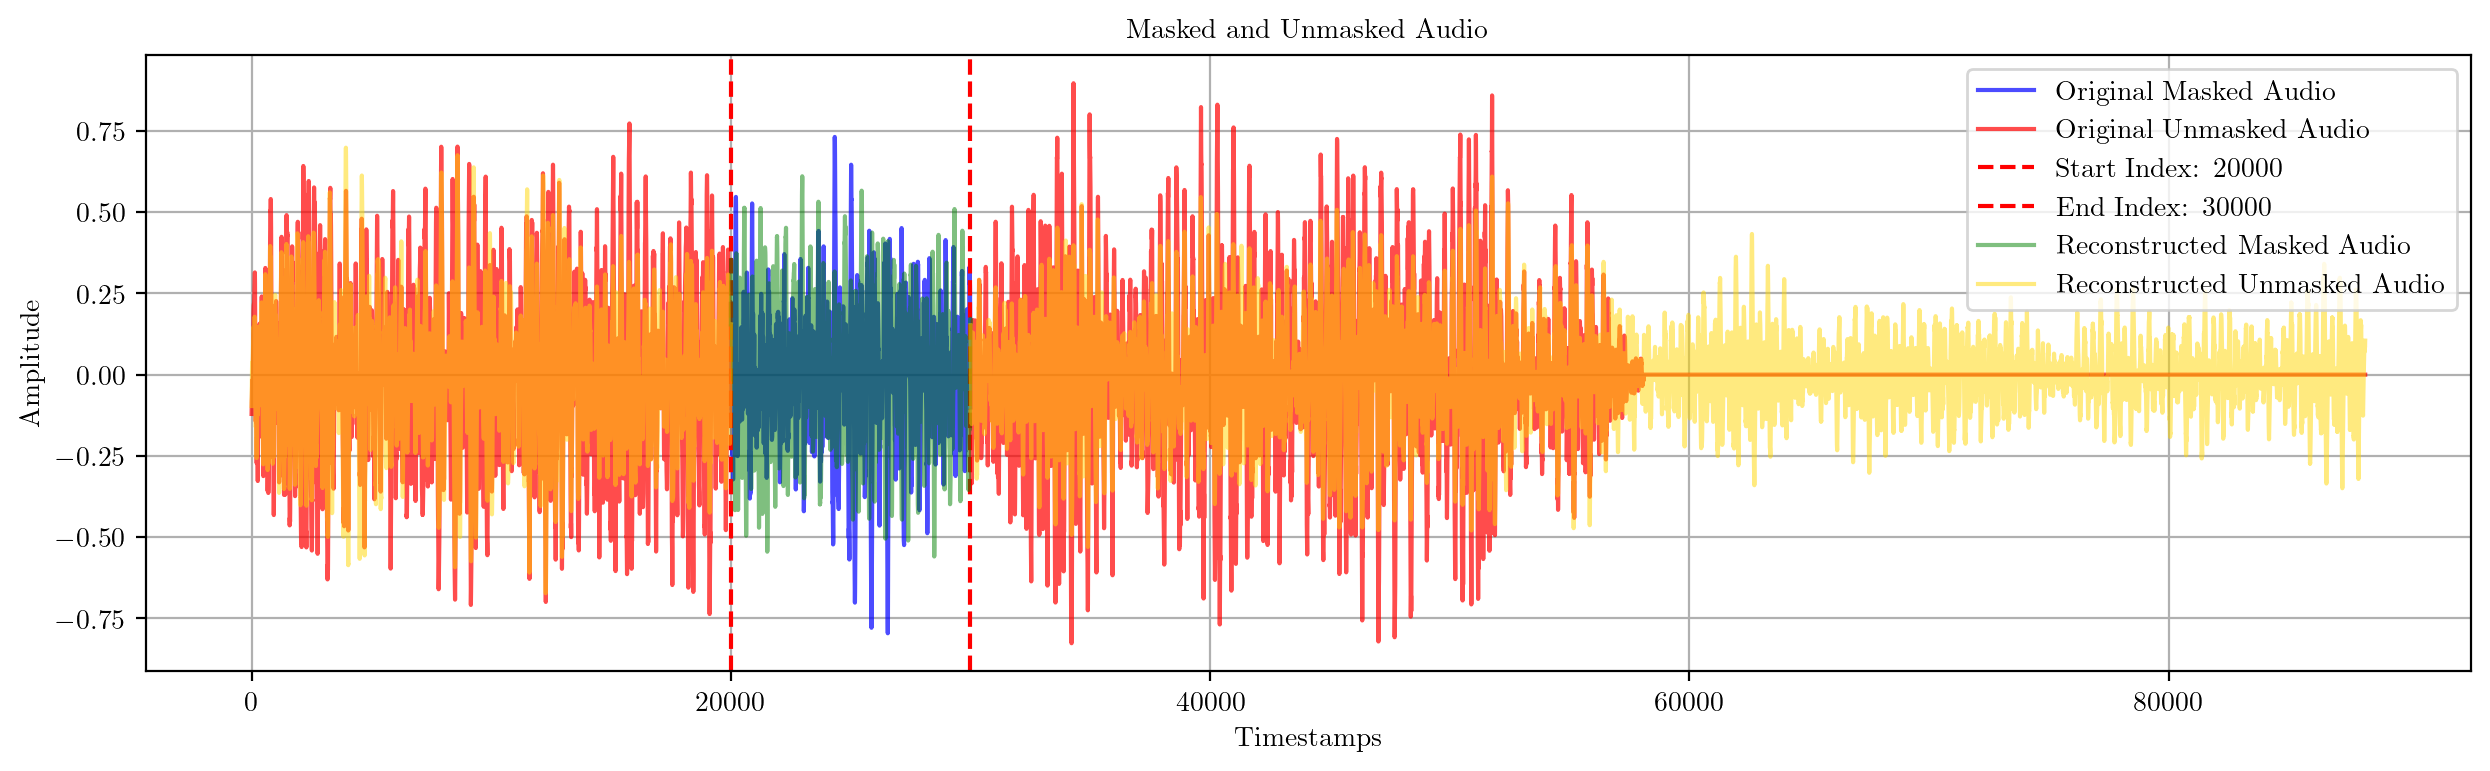

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(start_idx,end_idx), audio[start_idx:end_idx].numpy(), color = 'blue', alpha = 0.7, label = 'Original Masked Audio')
plt.plot(np.arange(start_idx), audio[:start_idx], color = 'red', alpha = 0.7, label = 'Original Unmasked Audio')
plt.plot(np.arange(end_idx, X.shape[0]), audio[end_idx:], color = 'red', alpha = 0.7)

plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')

plt.plot(np.arange(start_idx,end_idx), pred_audio[start_idx : end_idx], color = 'green', alpha = 0.5, label = 'Reconstructed Masked Audio')
plt.plot(np.arange(start_idx), pred_audio[:start_idx], color = 'gold', alpha = 0.5, label = 'Reconstructed Unmasked Audio')
plt.plot(np.arange(end_idx, X.shape[0]), pred_audio[end_idx:], color = 'gold', alpha = 0.5)

plt.xlabel('Timestamps')
plt.ylabel('Amplitude')
plt.title('Masked and Unmasked Audio')
plt.grid()
plt.legend()
plt.show()

### If trained on Raw Time Series Domain

In [ ]:
model = LinearRegression()
model.fit(X, audio)

pred_audio1 = model.predict(X)
print(pred_audio1.shape)

(88200,)


## **Line** will be the prediction

In [ ]:
print(pred_audio1)
print(audio)

[ 0.00018985  0.00018985  0.00018985 ... -0.00011585 -0.00011585
 -0.00011586]
tensor([-1.2097e-01, -1.1371e-01, -1.0635e-01,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])


In [ ]:
np.linalg.norm(pred_audio1 - audio.numpy()), np.linalg.norm((pred_audio1 - audio.numpy()), ord = 1)

(64.80844, 12420.989)

In [ ]:
Audio(pred_audio1, rate = sr)

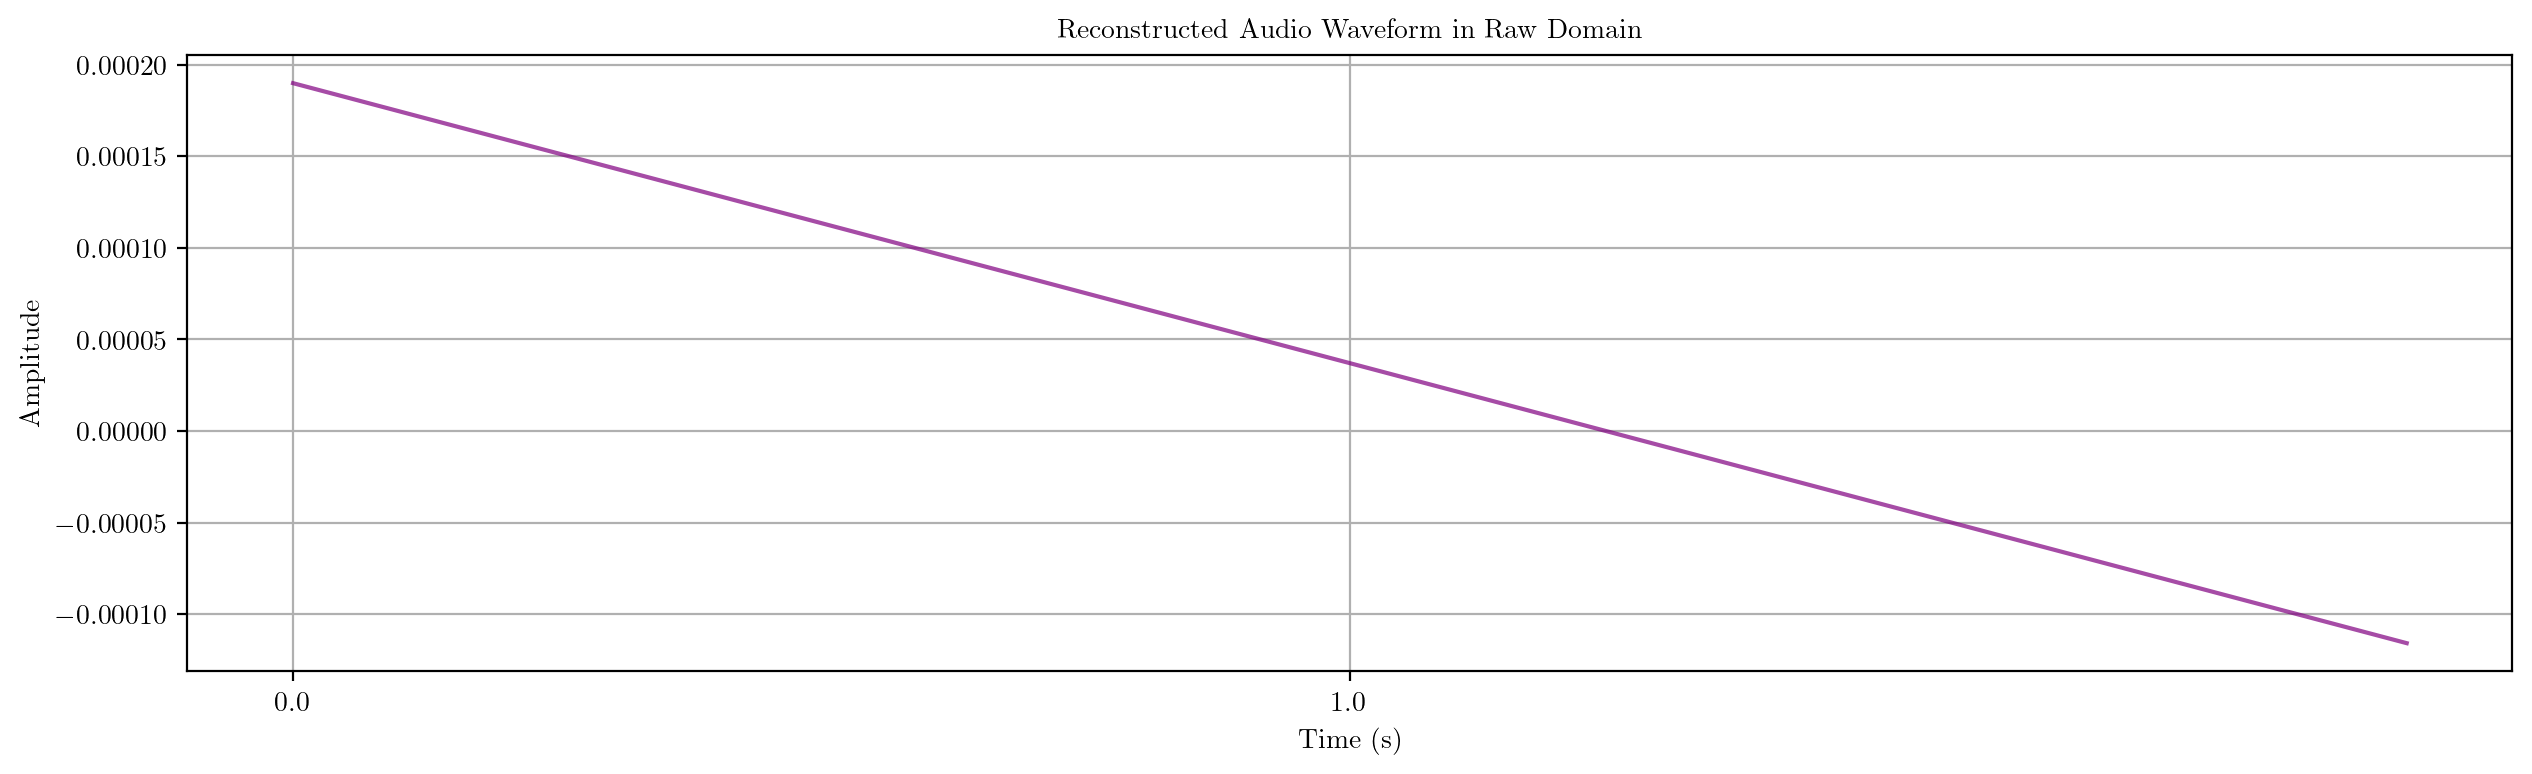

In [ ]:
audio_plot(pred_audio1, sr, 'purple', 'Reconstructed Audio Waveform in Raw Domain')

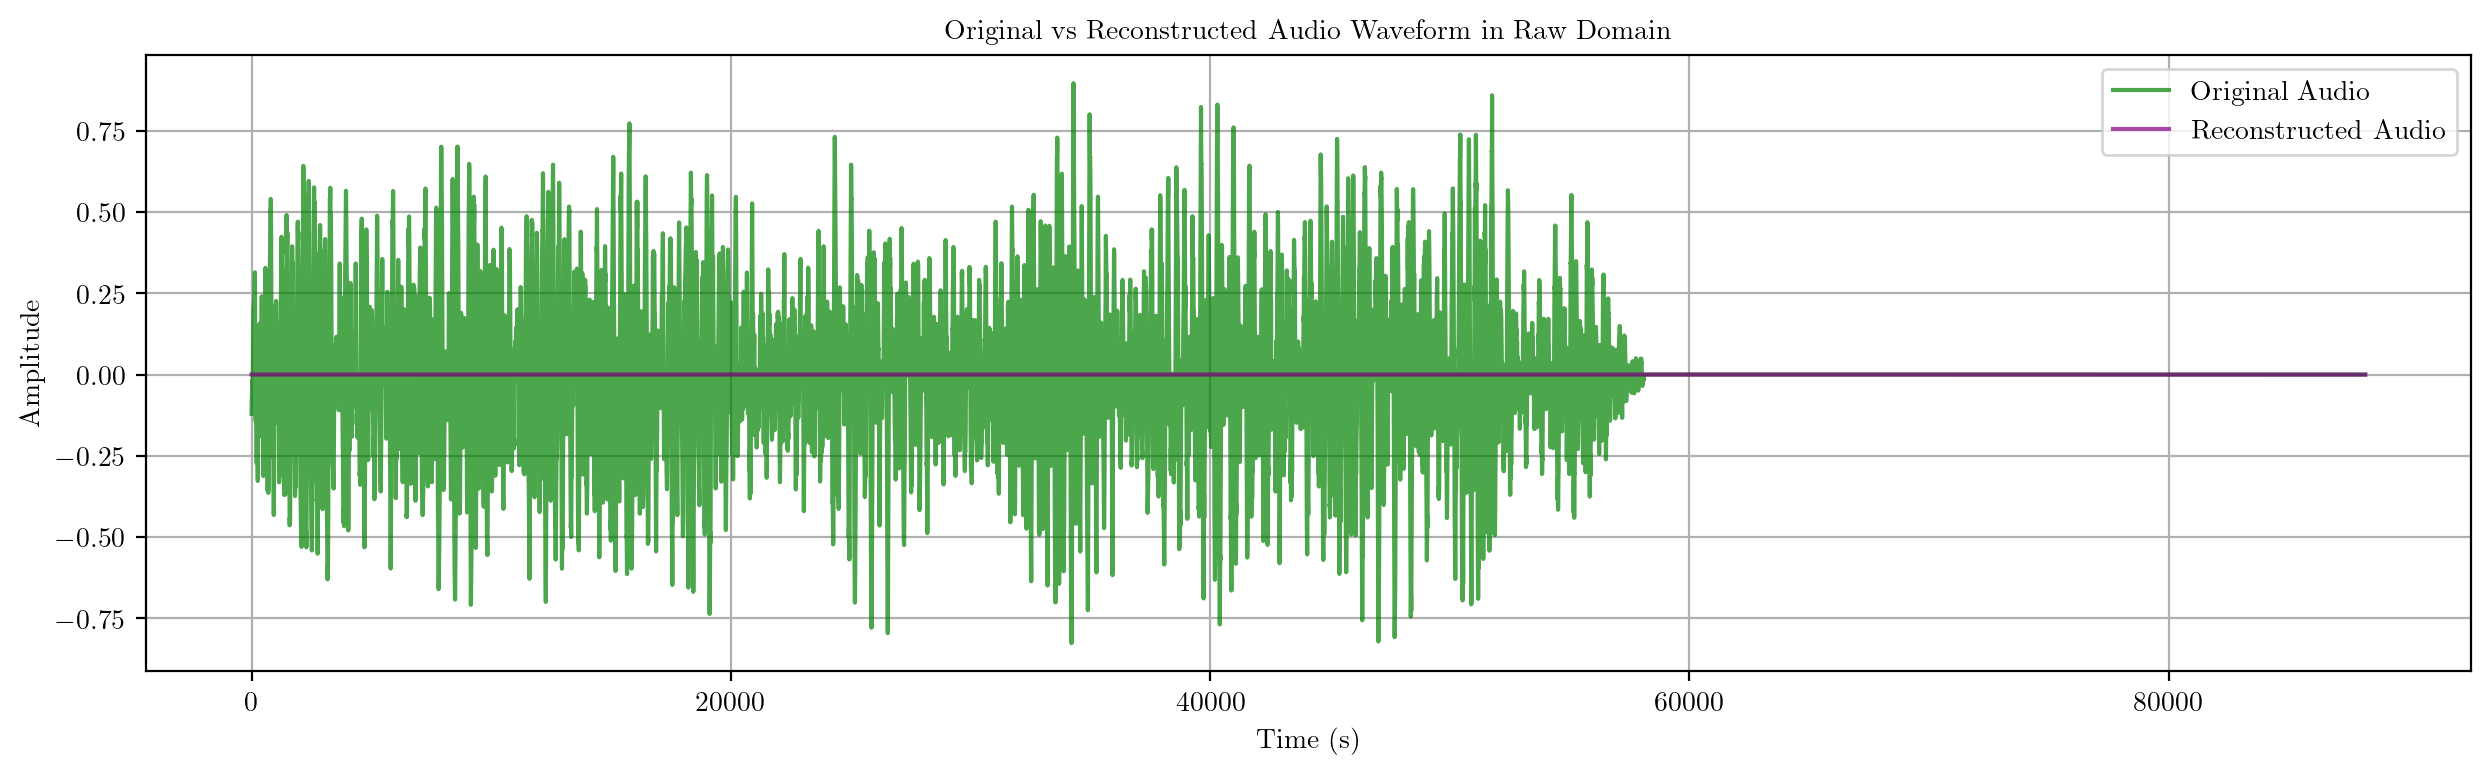

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'green', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio1, color = 'purple', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform in Raw Domain')
plt.grid()
plt.legend()
plt.show()